In [1]:
import torch
from torch.optim import Adam
import torch.nn.functional as F
from tqdm.auto import trange
import numpy as np
import matplotlib.pyplot as plt

from cloudmanufacturing.data import read_fatahi_dataset
from cloudmanufacturing.solvers.mip_solver import mip_solve
from cloudmanufacturing.validation import objvalue, construct_delta
from cloudmanufacturing.graph import dglgraph, graph_gamma, os_type, ss_type, so_type
from cloudmanufacturing.graphconv import GNN

c:\Users\dmitrii\miniconda3\envs\graph\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = read_fatahi_dataset('..\\data\\fatahi.xlsx')
len(dataset)

100%|██████████| 18/18 [00:02<00:00,  7.66it/s]


18

In [3]:
train_problem = dataset[0]
test_problem = dataset[2]
train_problem['name'], test_problem['name']

('5,10,10-1', '5,10,10-3')

In [4]:
train_gamma = np.load(f'solutions\\gamma_{0}.npy')
train_delta = np.load(f'solutions\\delta_{0}.npy')

test_gamma = np.load(f'solutions\\gamma_{2}.npy')
test_delta = np.load(f'solutions\\delta_{2}.npy')

In [5]:
# train_delta, train_gamma, status, value = mip_solve(train_problem)
# print(f'Problem {train_problem["name"]}: {value:.2f}, {status}')

In [6]:
# test_delta, test_gamma, status, value = mip_solve(test_problem)
# print(f'Problem {test_problem["name"]}: {value:.2f}, {status}')

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
def dglgraph_fixed(graph, oper_max=20):
        ncolumns = graph.ndata['feat']['o'].shape[1]
        graph.ndata['feat'] = {'o': F.pad(graph.ndata['feat']['o'], [0, oper_max - ncolumns])}
        return graph

In [9]:
train_graph = dglgraph(train_problem, train_gamma, train_delta).to(device)
train_graph = dglgraph_fixed(train_graph)
train_target = train_graph.edata['target'][os_type]
train_graph.edata['feat'][os_type][:, 0] /= 10
train_graph.edata['feat'][ss_type][:] /= 100

test_graph = dglgraph(test_problem, test_gamma,test_delta).to(device)
test_graph = dglgraph_fixed(test_graph)
test_target = test_graph.edata['target'][os_type]
test_graph.edata['feat'][os_type][:, 0] /= 10
test_graph.edata['feat'][ss_type][:] /= 100

In [10]:
model = GNN(s_shape=1, o_shape=20, os_shape=2,
            ss_shape=10, out_dim=15, n_layers=1).to(device)

In [11]:
train_loss = []
test_loss = []
train_objvalue = []
test_objvalue = []

In [16]:
optim = Adam(model.parameters(), lr=0.01)
train_mask = train_graph.edata["mask"][ss_type]
gamma_train = train_graph.edata["target"][os_type]
delta_train = train_graph.edata["delta_target"][ss_type]

test_mask = test_graph.edata["mask"][ss_type]
gamma_test = test_graph.edata["target"][os_type]
delta_test = test_graph.edata["delta_target"][ss_type]

for i in trange(800):
    logits, delta_logits = model(train_graph)
    operation_loss = F.binary_cross_entropy_with_logits(logits, gamma_train)
    service_loss = F.cross_entropy(delta_logits[train_mask], delta_train[train_mask])
    loss = operation_loss + service_loss
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % 10 == 0:
        with torch.no_grad():
            train_loss.append(loss.item())
            pred_gamma, pred_delta = model.predict(test_graph, train_problem)
            train_objvalue.append(
                objvalue(train_problem, pred_gamma, pred_delta)
            )
            logits, delta_logits = model(test_graph)
            operation_loss = F.binary_cross_entropy_with_logits(logits, gamma_test)
            service_loss = F.cross_entropy(delta_logits[test_mask], delta_test[test_mask])
            loss = operation_loss + service_loss
            test_loss.append(loss.item())
            pred_gamma, pred_delta = model.predict(test_graph, test_problem)
            test_objvalue.append(
                objvalue(test_problem, pred_gamma, pred_delta)
            )

  0%|          | 1/800 [00:00<03:32,  3.75it/s]

tensor([[ 1.6447e+01],
        [-8.0443e+00],
        [-2.1050e+01],
        [-4.9109e+01],
        [-5.4756e+01],
        [-3.5099e+01],
        [-6.2096e+00],
        [-6.3730e+00],
        [-1.0440e+01],
        [ 9.7345e+00],
        [-1.3734e+01],
        [-3.2335e+01],
        [ 6.5539e+00],
        [-6.0472e+01],
        [-1.4555e+01],
        [-2.0021e+01],
        [-4.8621e+01],
        [-2.8784e+01],
        [-3.2762e+01],
        [-2.7129e+01],
        [-4.8103e+00],
        [-1.0104e+01],
        [-1.3166e+01],
        [-5.2962e+00],
        [-1.0432e+01],
        [-1.2952e+01],
        [ 4.5850e+00],
        [-1.8046e+01],
        [-7.9615e+00],
        [-1.9701e+01],
        [-2.0158e+01],
        [-5.8581e+00],
        [-1.4954e+01],
        [-8.1325e+00],
        [-5.0392e+00],
        [ 4.2353e+00],
        [-2.1929e+01],
        [-1.8137e+01],
        [ 4.2053e+00],
        [-2.6071e+01],
        [-1.7216e+01],
        [-2.9524e+01],
        [-7.2514e+01],
        [-7

  0%|          | 4/800 [00:00<01:03, 12.63it/s]

tensor([[ -12.2713],
        [ -39.1010],
        [ -65.7788],
        [-104.3105],
        [-108.1504],
        [ -84.4390],
        [ -42.6571],
        [ -22.3684],
        [ -39.0921],
        [  -6.9745],
        [ -35.3956],
        [ -67.5921],
        [ -15.6386],
        [ -89.4831],
        [ -50.8103],
        [ -53.3866],
        [ -96.0796],
        [ -58.1496],
        [ -72.8785],
        [ -54.4626],
        [ -16.7643],
        [ -24.1859],
        [ -29.6959],
        [ -16.6368],
        [ -26.3646],
        [ -32.1163],
        [  -8.1175],
        [ -37.3315],
        [ -20.4285],
        [ -32.7492],
        [ -39.9818],
        [ -17.7150],
        [ -30.9839],
        [ -33.1921],
        [ -26.4355],
        [  -9.9578],
        [ -43.0534],
        [ -30.0226],
        [ -43.4019],
        [ -76.8962],
        [ -58.0625],
        [ -89.1255],
        [-143.6735],
        [-148.6886],
        [-108.1223],
        [ -52.3082],
        [ -86.6430],
        [ -11

  1%|          | 8/800 [00:00<00:38, 20.70it/s]

tensor([[  9.3739],
        [-11.3737],
        [-19.0123],
        [-49.9931],
        [-53.0419],
        [-36.4937],
        [ -6.6166],
        [-20.6485],
        [-24.5476],
        [  1.0923],
        [-28.1331],
        [-46.7971],
        [ -0.8726],
        [-63.6318],
        [-25.9627],
        [-27.2676],
        [-61.2894],
        [-35.2960],
        [-43.6546],
        [-31.0399],
        [-11.4494],
        [-15.8571],
        [-23.0396],
        [-10.3180],
        [-15.0603],
        [-19.3494],
        [ -0.2710],
        [-25.4610],
        [-12.1771],
        [-30.8680],
        [-39.4431],
        [-17.3471],
        [-28.3427],
        [-28.6579],
        [-24.9193],
        [ -6.6937],
        [-40.0596],
        [-27.1224],
        [  5.8544],
        [-30.0700],
        [-16.5119],
        [-20.0719],
        [-65.3379],
        [-68.7827],
        [-38.0736],
        [  0.8475],
        [-60.7988],
        [  7.4590],
        [-20.1558],
        [-60.0859],


  2%|▏         | 17/800 [00:00<00:38, 20.25it/s]

tensor([[ 8.3737e+00],
        [-9.6558e+00],
        [-1.6584e+01],
        [-4.2342e+01],
        [-4.5405e+01],
        [-3.2702e+01],
        [-6.3343e+00],
        [-1.1091e+01],
        [-4.2291e+00],
        [ 1.5068e+01],
        [-9.0915e+00],
        [-1.9031e+01],
        [ 7.3950e+00],
        [-5.2378e+01],
        [-1.1733e+01],
        [-1.4414e+01],
        [-4.3169e+01],
        [-2.3935e+01],
        [-3.0033e+01],
        [-2.1146e+01],
        [-6.0691e+00],
        [-9.6283e+00],
        [-1.3941e+01],
        [-4.1306e+00],
        [-6.2687e+00],
        [-7.2849e+00],
        [ 7.1892e+00],
        [-1.7189e+01],
        [-5.1202e+00],
        [-2.2099e+01],
        [-2.3088e+01],
        [-6.4804e+00],
        [-1.2043e+01],
        [-6.2761e+00],
        [-1.9550e+00],
        [ 7.8632e+00],
        [-2.4041e+01],
        [-1.3801e+01],
        [ 2.7629e+00],
        [-2.9872e+01],
        [-1.7955e+01],
        [-2.2502e+01],
        [-6.1580e+01],
        [-6

  2%|▎         | 20/800 [00:01<00:34, 22.61it/s]

tensor([[ 10.4678],
        [ -6.4834],
        [-11.0853],
        [-36.3408],
        [-38.6339],
        [-27.1307],
        [ -2.4093],
        [-14.1243],
        [ -9.2033],
        [ 12.3711],
        [-14.6758],
        [-28.5937],
        [ 11.0960],
        [-48.8202],
        [-10.8896],
        [-12.5074],
        [-45.2266],
        [-24.1774],
        [-30.0369],
        [-17.9232],
        [ -3.7700],
        [ -8.7665],
        [-16.0481],
        [ -4.6705],
        [ -6.2605],
        [-11.4995],
        [  4.9459],
        [-19.0138],
        [ -3.8153],
        [-22.2672],
        [-31.0443],
        [-10.4451],
        [-16.3331],
        [-17.9966],
        [-13.4600],
        [  2.1544],
        [-32.2923],
        [-15.0156],
        [  8.2954],
        [-23.9762],
        [-12.4729],
        [-13.4481],
        [-49.6035],
        [-53.4767],
        [-27.3699],
        [  2.2359],
        [-48.9977],
        [ 18.9263],
        [ -5.6939],
        [-40.9974],


  3%|▎         | 26/800 [00:01<00:38, 20.10it/s]

tensor([[  5.7581],
        [-10.0776],
        [-15.8540],
        [-42.3415],
        [-43.6424],
        [-32.8237],
        [ -6.7333],
        [-13.5473],
        [ -8.2387],
        [ 13.8539],
        [-11.9991],
        [-26.8413],
        [ 10.3081],
        [-49.6189],
        [-12.8618],
        [-13.2424],
        [-47.8782],
        [-25.9991],
        [-32.2751],
        [-18.5408],
        [ -5.9533],
        [-11.4214],
        [-19.2379],
        [ -6.3645],
        [ -8.3432],
        [-14.3989],
        [  2.4661],
        [-22.4409],
        [ -4.9002],
        [-24.0670],
        [-34.7471],
        [-11.8479],
        [-17.8760],
        [-22.9159],
        [-16.7804],
        [ -0.2684],
        [-36.4630],
        [-14.9977],
        [  0.2924],
        [-31.5427],
        [-17.8138],
        [-20.9309],
        [-57.3395],
        [-60.2030],
        [-35.1760],
        [ -5.3107],
        [-50.6432],
        [ 17.9396],
        [ -6.5204],
        [-43.5064],


  4%|▍         | 30/800 [00:01<00:31, 24.16it/s]

tensor([[  9.2141],
        [ -5.3668],
        [ -9.8250],
        [-32.5928],
        [-34.2026],
        [-25.0815],
        [ -2.4138],
        [-11.1522],
        [ -3.0087],
        [ 16.6941],
        [ -8.6359],
        [-21.8839],
        [ 14.4896],
        [-44.3274],
        [ -5.5392],
        [ -7.4591],
        [-39.1127],
        [-20.4660],
        [-25.2208],
        [-13.5996],
        [ -3.9040],
        [ -8.7164],
        [-14.7606],
        [ -3.2457],
        [ -4.1419],
        [ -7.7865],
        [  6.0787],
        [-17.7153],
        [ -1.4644],
        [-18.7603],
        [-25.9688],
        [ -5.9285],
        [ -9.6855],
        [-11.1441],
        [ -5.3645],
        [  7.4771],
        [-28.2867],
        [ -7.8497],
        [  5.0517],
        [-24.2547],
        [-12.9613],
        [-14.7785],
        [-46.0723],
        [-49.5377],
        [-26.3442],
        [ -1.6114],
        [-45.0475],
        [ 23.3084],
        [  0.1039],
        [-33.2648],


  5%|▍         | 37/800 [00:01<00:35, 21.40it/s]

tensor([[  6.1127],
        [ -7.9483],
        [-13.0746],
        [-36.7511],
        [-37.7985],
        [-28.8471],
        [ -5.1716],
        [-13.0419],
        [ -6.2115],
        [ 15.0255],
        [-10.3615],
        [-24.9721],
        [ 11.2675],
        [-47.6779],
        [-10.7174],
        [-11.3355],
        [-45.0406],
        [-24.2797],
        [-30.0259],
        [-16.5174],
        [ -6.7389],
        [-11.1669],
        [-17.2759],
        [ -4.7952],
        [ -6.1432],
        [ -9.2861],
        [  4.3352],
        [-19.9927],
        [ -3.1081],
        [-20.0939],
        [-27.2638],
        [ -6.4867],
        [-10.4640],
        [-12.4736],
        [ -6.0957],
        [  6.7059],
        [-29.6752],
        [ -8.2043],
        [  1.4910],
        [-27.8853],
        [-15.7753],
        [-18.4270],
        [-50.2175],
        [-53.1227],
        [-30.3711],
        [ -5.0366],
        [-49.6197],
        [ 19.2335],
        [ -4.6767],
        [-40.3741],


  6%|▌         | 47/800 [00:02<00:34, 21.75it/s]

tensor([[ 7.1727e+00],
        [-6.4653e+00],
        [-1.1056e+01],
        [-3.4055e+01],
        [-3.4915e+01],
        [-2.6160e+01],
        [-3.8193e+00],
        [-1.6695e+01],
        [-1.2566e+01],
        [ 1.1386e+01],
        [-1.6140e+01],
        [-3.4043e+01],
        [ 9.6531e+00],
        [-4.9887e+01],
        [-1.4139e+01],
        [-1.3769e+01],
        [-4.9692e+01],
        [-2.7076e+01],
        [-3.3067e+01],
        [-1.8080e+01],
        [-8.2690e+00],
        [-1.2383e+01],
        [-1.8516e+01],
        [-5.5655e+00],
        [-7.1469e+00],
        [-9.6811e+00],
        [ 3.2886e+00],
        [-2.0554e+01],
        [-4.3194e+00],
        [-1.9616e+01],
        [-2.7265e+01],
        [-6.3039e+00],
        [-1.0660e+01],
        [-1.2804e+01],
        [-6.5931e+00],
        [ 6.4576e+00],
        [-2.9832e+01],
        [-8.7854e+00],
        [ 4.4319e+00],
        [-2.3976e+01],
        [-1.3113e+01],
        [-1.4564e+01],
        [-4.4330e+01],
        [-4

  7%|▋         | 54/800 [00:02<00:36, 20.28it/s]

tensor([[ 7.9642e+00],
        [-5.7715e+00],
        [-1.0606e+01],
        [-3.3475e+01],
        [-3.4449e+01],
        [-2.5419e+01],
        [-3.5280e+00],
        [-1.6119e+01],
        [-1.2399e+01],
        [ 1.1924e+01],
        [-1.5875e+01],
        [-3.4660e+01],
        [ 1.0413e+01],
        [-4.9875e+01],
        [-1.3736e+01],
        [-1.3354e+01],
        [-4.9859e+01],
        [-2.7152e+01],
        [-3.2920e+01],
        [-1.7875e+01],
        [-6.5691e+00],
        [-1.1333e+01],
        [-1.7647e+01],
        [-5.0528e+00],
        [-6.6596e+00],
        [-1.0153e+01],
        [ 3.5649e+00],
        [-2.0107e+01],
        [-3.7153e+00],
        [-1.8199e+01],
        [-2.6001e+01],
        [-5.4063e+00],
        [-1.0092e+01],
        [-1.2340e+01],
        [-6.3632e+00],
        [ 6.8133e+00],
        [-2.9182e+01],
        [-8.5248e+00],
        [ 4.3539e+00],
        [-2.3540e+01],
        [-1.2830e+01],
        [-1.4587e+01],
        [-4.3995e+01],
        [-4

  7%|▋         | 57/800 [00:02<00:34, 21.53it/s]

tensor([[  7.3615],
        [ -6.5243],
        [-11.6524],
        [-34.9312],
        [-35.9328],
        [-26.9144],
        [ -4.2577],
        [-15.8954],
        [-12.3930],
        [ 12.1133],
        [-15.5547],
        [-34.5303],
        [  9.9566],
        [-50.5235],
        [-14.7273],
        [-14.0626],
        [-51.0653],
        [-27.9088],
        [-33.9111],
        [-18.4824],
        [ -6.5056],
        [-11.3563],
        [-18.0202],
        [ -5.3525],
        [ -7.0577],
        [-10.9350],
        [  3.4019],
        [-20.6497],
        [ -3.9348],
        [-18.1179],
        [-26.1868],
        [ -5.6211],
        [-10.4546],
        [-12.8455],
        [ -7.0132],
        [  6.5842],
        [-29.5033],
        [ -8.8275],
        [  3.5733],
        [-24.8398],
        [-13.7277],
        [-15.8486],
        [-45.9229],
        [-48.4505],
        [-26.6534],
        [ -3.2632],
        [-53.6421],
        [ 17.2095],
        [ -8.3777],
        [-47.7524],


  8%|▊         | 64/800 [00:03<00:36, 19.95it/s]

tensor([[  7.7220],
        [ -6.2788],
        [-11.3756],
        [-34.6099],
        [-35.7228],
        [-26.7646],
        [ -3.9719],
        [-15.7756],
        [-12.3245],
        [ 12.2506],
        [-15.5457],
        [-34.5964],
        [ 10.1957],
        [-50.3756],
        [-14.4936],
        [-13.8180],
        [-50.8179],
        [-27.7139],
        [-33.6803],
        [-18.3181],
        [ -6.2462],
        [-11.1848],
        [-18.0182],
        [ -5.2819],
        [ -6.9820],
        [-10.9332],
        [  3.8545],
        [-20.7645],
        [ -3.8774],
        [-17.9419],
        [-26.1183],
        [ -5.6598],
        [-10.5737],
        [-12.8148],
        [ -7.1928],
        [  6.6426],
        [-29.4524],
        [ -9.0571],
        [  3.9544],
        [-24.5969],
        [-13.4600],
        [-15.5033],
        [-45.6152],
        [-48.1840],
        [-26.4533],
        [ -2.8332],
        [-53.3735],
        [ 17.5400],
        [ -8.0706],
        [-47.4294],


  9%|▉         | 70/800 [00:03<00:32, 22.81it/s]

tensor([[  7.5910],
        [ -6.4169],
        [-11.6493],
        [-34.9596],
        [-36.1078],
        [-27.1806],
        [ -4.1574],
        [-15.6335],
        [-12.1558],
        [ 12.5787],
        [-15.3059],
        [-34.4026],
        [ 10.2167],
        [-50.5696],
        [-14.5392],
        [-13.7567],
        [-50.8702],
        [-27.7435],
        [-33.7538],
        [-18.4014],
        [ -6.4764],
        [-11.5396],
        [-18.5777],
        [ -5.4819],
        [ -7.2988],
        [-11.2137],
        [  4.2999],
        [-21.5017],
        [ -4.1602],
        [-18.2576],
        [-26.5184],
        [ -5.9571],
        [-11.1226],
        [-13.2446],
        [ -7.7325],
        [  6.4079],
        [-29.8627],
        [ -9.7115],
        [  3.4174],
        [-25.2008],
        [-13.7689],
        [-15.9764],
        [-46.2282],
        [-48.6481],
        [-27.1180],
        [ -3.1172],
        [-53.3243],
        [ 17.8173],
        [ -7.8550],
        [-47.3140],


 10%|▉         | 76/800 [00:03<00:36, 19.99it/s]

tensor([[ 7.7598e+00],
        [-6.3379e+00],
        [-1.1535e+01],
        [-3.4840e+01],
        [-3.6062e+01],
        [-2.7120e+01],
        [-4.0090e+00],
        [-1.5579e+01],
        [-1.2120e+01],
        [ 1.2673e+01],
        [-1.5332e+01],
        [-3.4430e+01],
        [ 1.0327e+01],
        [-5.0508e+01],
        [-1.4442e+01],
        [-1.3626e+01],
        [-5.0733e+01],
        [-2.7634e+01],
        [-3.3627e+01],
        [-1.8318e+01],
        [-6.6050e+00],
        [-1.1638e+01],
        [-1.8870e+01],
        [-5.6235e+00],
        [-7.4764e+00],
        [-1.1349e+01],
        [ 4.5388e+00],
        [-2.1805e+01],
        [-4.3500e+00],
        [-1.8339e+01],
        [-2.6701e+01],
        [-6.1647e+00],
        [-1.1421e+01],
        [-1.3391e+01],
        [-8.0555e+00],
        [ 6.3397e+00],
        [-2.9986e+01],
        [-1.0078e+01],
        [ 3.7497e+00],
        [-2.5052e+01],
        [-1.3623e+01],
        [-1.5731e+01],
        [-4.6052e+01],
        [-4

 10%|▉         | 79/800 [00:04<00:32, 21.93it/s]

tensor([[ 7.4457e+00],
        [-6.7475e+00],
        [-1.2039e+01],
        [-3.5520e+01],
        [-3.6774e+01],
        [-2.7744e+01],
        [-4.3318e+00],
        [-1.5447e+01],
        [-1.1975e+01],
        [ 1.2876e+01],
        [-1.5132e+01],
        [-3.4158e+01],
        [ 1.0140e+01],
        [-5.0762e+01],
        [-1.4788e+01],
        [-1.3841e+01],
        [-5.1068e+01],
        [-2.7844e+01],
        [-3.3932e+01],
        [-1.8533e+01],
        [-7.0947e+00],
        [-1.2041e+01],
        [-1.9587e+01],
        [-6.0585e+00],
        [-8.0229e+00],
        [-1.1868e+01],
        [ 4.5549e+00],
        [-2.2534e+01],
        [-4.8232e+00],
        [-1.8667e+01],
        [-2.7135e+01],
        [-6.5675e+00],
        [-1.1952e+01],
        [-1.3790e+01],
        [-8.6063e+00],
        [ 6.1213e+00],
        [-3.0345e+01],
        [-1.0616e+01],
        [ 3.6249e+00],
        [-2.5566e+01],
        [-1.4012e+01],
        [-1.6186e+01],
        [-4.6848e+01],
        [-4

 11%|█         | 85/800 [00:04<00:37, 18.88it/s]

tensor([[ 7.4779e+00],
        [-6.7969e+00],
        [-1.2129e+01],
        [-3.5664e+01],
        [-3.6970e+01],
        [-2.7888e+01],
        [-4.3571e+00],
        [-1.5275e+01],
        [-1.1721e+01],
        [ 1.3109e+01],
        [-1.4911e+01],
        [-3.3857e+01],
        [ 1.0216e+01],
        [-5.0751e+01],
        [-1.4696e+01],
        [-1.3742e+01],
        [-5.0945e+01],
        [-2.7765e+01],
        [-3.3846e+01],
        [-1.8496e+01],
        [-7.1982e+00],
        [-1.2186e+01],
        [-1.9899e+01],
        [-6.1907e+00],
        [-8.2110e+00],
        [-1.2079e+01],
        [ 4.7616e+00],
        [-2.2924e+01],
        [-4.9781e+00],
        [-1.8764e+01],
        [-2.7215e+01],
        [-6.6794e+00],
        [-1.2133e+01],
        [-1.3821e+01],
        [-8.7310e+00],
        [ 6.1105e+00],
        [-3.0402e+01],
        [-1.0849e+01],
        [ 3.6674e+00],
        [-2.5679e+01],
        [-1.4081e+01],
        [-1.6279e+01],
        [-4.7066e+01],
        [-4

 11%|█         | 89/800 [00:04<00:32, 22.07it/s]

tensor([[  7.6507],
        [ -6.7604],
        [-12.1677],
        [-35.7833],
        [-37.1766],
        [-28.0144],
        [ -4.3248],
        [-14.9914],
        [-11.3078],
        [ 13.4899],
        [-14.5510],
        [-33.4197],
        [ 10.4187],
        [-50.6878],
        [-14.4341],
        [-13.5059],
        [-50.6632],
        [-27.5873],
        [-33.6245],
        [-18.3821],
        [ -7.1948],
        [-12.3290],
        [-20.2548],
        [ -6.2887],
        [ -8.3874],
        [-12.3495],
        [  5.1413],
        [-23.4481],
        [ -5.1011],
        [-18.8444],
        [-27.2324],
        [ -6.7429],
        [-12.3054],
        [-13.7912],
        [ -8.8022],
        [  6.1316],
        [-30.4210],
        [-11.1178],
        [  3.7084],
        [-25.7928],
        [-14.1177],
        [-16.3817],
        [-47.3242],
        [-49.7428],
        [-27.9191],
        [ -2.8756],
        [-52.9789],
        [ 18.4215],
        [ -7.3222],
        [-46.8173],


 12%|█▏        | 95/800 [00:04<00:36, 19.34it/s]

tensor([[ 7.5981e+00],
        [-6.9082e+00],
        [-1.2411e+01],
        [-3.6166e+01],
        [-3.7595e+01],
        [-2.8363e+01],
        [-4.4724e+00],
        [-1.4851e+01],
        [-1.1151e+01],
        [ 1.3676e+01],
        [-1.4352e+01],
        [-3.3231e+01],
        [ 1.0401e+01],
        [-5.0810e+01],
        [-1.4518e+01],
        [-1.3554e+01],
        [-5.0786e+01],
        [-2.7668e+01],
        [-3.3732e+01],
        [-1.8463e+01],
        [-7.2587e+00],
        [-1.2483e+01],
        [-2.0572e+01],
        [-6.4284e+00],
        [-8.5936e+00],
        [-1.2669e+01],
        [ 5.2397e+00],
        [-2.3871e+01],
        [-5.2344e+00],
        [-1.8953e+01],
        [-2.7346e+01],
        [-6.8385e+00],
        [-1.2479e+01],
        [-1.3927e+01],
        [-8.9645e+00],
        [ 6.0521e+00],
        [-3.0544e+01],
        [-1.1309e+01],
        [ 3.5743e+00],
        [-2.6096e+01],
        [-1.4319e+01],
        [-1.6688e+01],
        [-4.7844e+01],
        [-5

 12%|█▏        | 98/800 [00:05<00:32, 21.37it/s]

tensor([[ 7.7635e+00],
        [-6.9363e+00],
        [-1.2513e+01],
        [-3.6438e+01],
        [-3.7953e+01],
        [-2.8606e+01],
        [-4.4691e+00],
        [-1.4713e+01],
        [-1.1071e+01],
        [ 1.3830e+01],
        [-1.4256e+01],
        [-3.3235e+01],
        [ 1.0466e+01],
        [-5.0887e+01],
        [-1.4549e+01],
        [-1.3557e+01],
        [-5.0894e+01],
        [-2.7722e+01],
        [-3.3790e+01],
        [-1.8492e+01],
        [-7.2186e+00],
        [-1.2547e+01],
        [-2.0879e+01],
        [-6.5572e+00],
        [-8.7802e+00],
        [-1.3039e+01],
        [ 5.3936e+00],
        [-2.4286e+01],
        [-5.3397e+00],
        [-1.8991e+01],
        [-2.7434e+01],
        [-6.9319e+00],
        [-1.2665e+01],
        [-1.4068e+01],
        [-9.1813e+00],
        [ 5.9697e+00],
        [-3.0641e+01],
        [-1.1525e+01],
        [ 3.7545e+00],
        [-2.6190e+01],
        [-1.4354e+01],
        [-1.6770e+01],
        [-4.8204e+01],
        [-5

 13%|█▎        | 104/800 [00:05<00:37, 18.45it/s]

tensor([[ 7.7617e+00],
        [-7.0419e+00],
        [-1.2719e+01],
        [-3.6799e+01],
        [-3.8349e+01],
        [-2.8935e+01],
        [-4.5896e+00],
        [-1.4620e+01],
        [-1.1007e+01],
        [ 1.3961e+01],
        [-1.4134e+01],
        [-3.3193e+01],
        [ 1.0449e+01],
        [-5.1029e+01],
        [-1.4647e+01],
        [-1.3621e+01],
        [-5.1064e+01],
        [-2.7832e+01],
        [-3.3920e+01],
        [-1.8583e+01],
        [-7.2891e+00],
        [-1.2682e+01],
        [-2.1134e+01],
        [-6.6826e+00],
        [-8.9601e+00],
        [-1.3310e+01],
        [ 5.4149e+00],
        [-2.4607e+01],
        [-5.4535e+00],
        [-1.9099e+01],
        [-2.7554e+01],
        [-7.0024e+00],
        [-1.2819e+01],
        [-1.4237e+01],
        [-9.3393e+00],
        [ 5.8633e+00],
        [-3.0782e+01],
        [-1.1692e+01],
        [ 3.6000e+00],
        [-2.6487e+01],
        [-1.4531e+01],
        [-1.7064e+01],
        [-4.8704e+01],
        [-5

 14%|█▎        | 108/800 [00:05<00:31, 22.07it/s]

tensor([[ 7.9930e+00],
        [-6.9958e+00],
        [-1.2750e+01],
        [-3.6983e+01],
        [-3.8620e+01],
        [-2.9105e+01],
        [-4.5398e+00],
        [-1.4486e+01],
        [-1.0923e+01],
        [ 1.4117e+01],
        [-1.4037e+01],
        [-3.3220e+01],
        [ 1.0555e+01],
        [-5.1078e+01],
        [-1.4597e+01],
        [-1.3571e+01],
        [-5.1096e+01],
        [-2.7842e+01],
        [-3.3909e+01],
        [-1.8572e+01],
        [-7.2563e+00],
        [-1.2715e+01],
        [-2.1325e+01],
        [-6.7595e+00],
        [-9.0704e+00],
        [-1.3528e+01],
        [ 5.5450e+00],
        [-2.4866e+01],
        [-5.5034e+00],
        [-1.9124e+01],
        [-2.7575e+01],
        [-7.0172e+00],
        [-1.2915e+01],
        [-1.4296e+01],
        [-9.4206e+00],
        [ 5.8220e+00],
        [-3.0824e+01],
        [-1.1831e+01],
        [ 3.7150e+00],
        [-2.6579e+01],
        [-1.4545e+01],
        [-1.7149e+01],
        [-4.9016e+01],
        [-5

 14%|█▍        | 115/800 [00:05<00:32, 21.27it/s]

tensor([[ 8.0327e+00],
        [-7.0686e+00],
        [-1.2897e+01],
        [-3.7259e+01],
        [-3.8939e+01],
        [-2.9358e+01],
        [-4.6079e+00],
        [-1.4401e+01],
        [-1.0874e+01],
        [ 1.4214e+01],
        [-1.3950e+01],
        [-3.3211e+01],
        [ 1.0548e+01],
        [-5.1180e+01],
        [-1.4673e+01],
        [-1.3630e+01],
        [-5.1235e+01],
        [-2.7926e+01],
        [-3.4007e+01],
        [-1.8635e+01],
        [-7.2938e+00],
        [-1.2779e+01],
        [-2.1497e+01],
        [-6.8485e+00],
        [-9.1850e+00],
        [-1.3710e+01],
        [ 5.5747e+00],
        [-2.5079e+01],
        [-5.5621e+00],
        [-1.9175e+01],
        [-2.7616e+01],
        [-7.0427e+00],
        [-1.2984e+01],
        [-1.4358e+01],
        [-9.4759e+00],
        [ 5.7814e+00],
        [-3.0880e+01],
        [-1.1910e+01],
        [ 3.6752e+00],
        [-2.6786e+01],
        [-1.4673e+01],
        [-1.7362e+01],
        [-4.9421e+01],
        [-5

 15%|█▌        | 122/800 [00:06<00:33, 20.38it/s]

tensor([[ 8.2082e+00],
        [-7.1194e+00],
        [-1.3061e+01],
        [-3.7642e+01],
        [-3.9419e+01],
        [-2.9718e+01],
        [-4.6422e+00],
        [-1.4250e+01],
        [-1.0798e+01],
        [ 1.4379e+01],
        [-1.3832e+01],
        [-3.3254e+01],
        [ 1.0589e+01],
        [-5.1320e+01],
        [-1.4737e+01],
        [-1.3682e+01],
        [-5.1414e+01],
        [-2.8024e+01],
        [-3.4111e+01],
        [-1.8696e+01],
        [-7.3265e+00],
        [-1.2858e+01],
        [-2.1778e+01],
        [-6.9811e+00],
        [-9.3484e+00],
        [-1.3988e+01],
        [ 5.6821e+00],
        [-2.5429e+01],
        [-5.6306e+00],
        [-1.9245e+01],
        [-2.7652e+01],
        [-7.0592e+00],
        [-1.3073e+01],
        [-1.4411e+01],
        [-9.5173e+00],
        [ 5.7460e+00],
        [-3.0939e+01],
        [-1.2028e+01],
        [ 3.7056e+00],
        [-2.7064e+01],
        [-1.4822e+01],
        [-1.7641e+01],
        [-5.0025e+01],
        [-5

 16%|█▌        | 124/800 [00:06<00:34, 19.62it/s]


tensor([[ 8.3061e+00],
        [-7.1074e+00],
        [-1.3079e+01],
        [-3.7730e+01],
        [-3.9545e+01],
        [-2.9803e+01],
        [-4.6198e+00],
        [-1.4205e+01],
        [-1.0786e+01],
        [ 1.4426e+01],
        [-1.3815e+01],
        [-3.3303e+01],
        [ 1.0620e+01],
        [-5.1353e+01],
        [-1.4738e+01],
        [-1.3685e+01],
        [-5.1456e+01],
        [-2.8043e+01],
        [-3.4125e+01],
        [-1.8700e+01],
        [-7.3222e+00],
        [-1.2870e+01],
        [-2.1867e+01],
        [-7.0179e+00],
        [-9.3910e+00],
        [-1.4073e+01],
        [ 5.7376e+00],
        [-2.5540e+01],
        [-5.6424e+00],
        [-1.9260e+01],
        [-2.7658e+01],
        [-7.0594e+00],
        [-1.3096e+01],
        [-1.4416e+01],
        [-9.5223e+00],
        [ 5.7428e+00],
        [-3.0949e+01],
        [-1.2066e+01],
        [ 3.7646e+00],
        [-2.7116e+01],
        [-1.4839e+01],
        [-1.7687e+01],
        [-5.0176e+01],
        [-5

KeyboardInterrupt: 

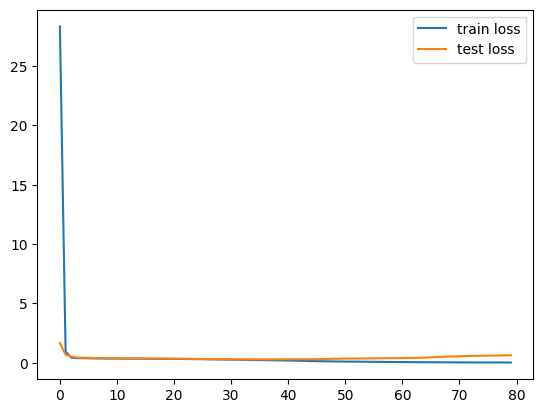

In [13]:
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()

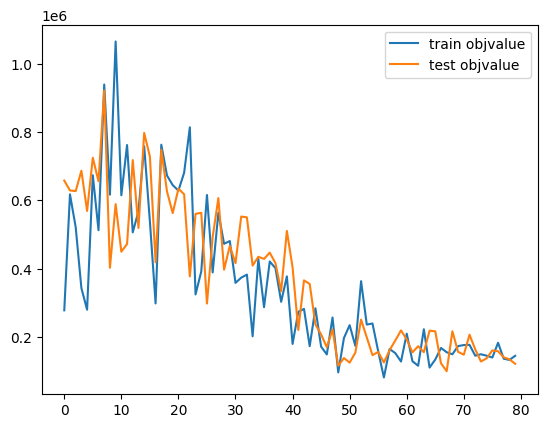

In [14]:
plt.plot(train_objvalue, label='train objvalue')
plt.plot(test_objvalue, label='test objvalue')
plt.legend()
plt.show()

In [15]:
min(train_objvalue), min(test_objvalue)

(80860.70402373282, 99247.05837575911)